In [1]:
!pip3 install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install findspark

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import findspark
findspark.init('/home/ubuntu/spark-3.3.1-bin-hadoop3')
findspark.find()

'/home/ubuntu/spark-3.3.1-bin-hadoop3'

In [6]:
from pyspark.sql import SparkSession

# The entry point into all functionality in Spark is the SparkSession class.
spark = (SparkSession
	.builder
	.appName("DS5110/CS5501: my awesome Spark program - balanced att2 - on 022118 dataset")
	.master("spark://172.31.8.146:7077")
	.config("spark.executor.memory", "1024M")
	.getOrCreate())

In [7]:
spark

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import col, count, desc, rand, when

from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import functions as F


## specify the data type of each column 

In [9]:
# Define the schema for the DataFrame
schema = StructType([
    StructField('Dst Port', IntegerType()),
    StructField('Protocol', IntegerType()),
    StructField('Timestamp', StringType()),
    StructField('Flow Duration', IntegerType()),
    StructField('Tot Fwd Pkts', IntegerType()),
    StructField('Tot Bwd Pkts', IntegerType()),
    StructField('TotLen Fwd Pkts', FloatType()),
    StructField('TotLen Bwd Pkts', FloatType()),
    StructField('Fwd Pkt Len Max', FloatType()),
    StructField('Fwd Pkt Len Min', FloatType()),
    StructField('Fwd Pkt Len Mean', FloatType()),
    StructField('Fwd Pkt Len Std', FloatType()),
    StructField('Bwd Pkt Len Max', FloatType()),
    StructField('Bwd Pkt Len Min', FloatType()),
    StructField('Bwd Pkt Len Mean', FloatType()),
    StructField('Bwd Pkt Len Std', FloatType()),
    StructField('Flow Byts/s', FloatType()),
    StructField('Flow Pkts/s', FloatType()),
    StructField('Flow IAT Mean', FloatType()),
    StructField('Flow IAT Std', FloatType()),
    StructField('Flow IAT Max', FloatType()),
    StructField('Flow IAT Min', FloatType()),
    StructField('Fwd IAT Tot', FloatType()),
    StructField('Fwd IAT Mean', FloatType()),
    StructField('Fwd IAT Std', FloatType()),
    StructField('Fwd IAT Max', FloatType()),
    StructField('Fwd IAT Min', FloatType()),
    StructField('Bwd IAT Tot', FloatType()),
    StructField('Bwd IAT Mean', FloatType()),
    StructField('Bwd IAT Std', FloatType()),
    StructField('Bwd IAT Max', FloatType()),
    StructField('Bwd IAT Min', FloatType()),
    StructField('Fwd PSH Flags', IntegerType()),
    StructField('Bwd PSH Flags', IntegerType()),
    StructField('Fwd URG Flags', IntegerType()),
    StructField('Bwd URG Flags', IntegerType()),
    StructField('Fwd Header Len', IntegerType()),
    StructField('Bwd Header Len', IntegerType()),
    StructField('Fwd Pkts/s', FloatType()),
    StructField('Bwd Pkts/s', FloatType()),
    StructField('Pkt Len Min', FloatType()),
    StructField('Pkt Len Max', FloatType()),
    StructField('Pkt Len Mean', FloatType()),
    StructField('Pkt Len Std', FloatType()),
    StructField('Pkt Len Var', FloatType()),
    StructField('FIN Flag Cnt', IntegerType()),
    StructField('SYN Flag Cnt', IntegerType()),
    StructField('RST Flag Cnt', IntegerType()),
    StructField('PSH Flag Cnt', IntegerType()),
    StructField('ACK Flag Cnt', IntegerType()),
    StructField('URG Flag Cnt', IntegerType()),
    StructField('CWE Flag Count', IntegerType()),
    StructField('ECE Flag Cnt', IntegerType()),
    StructField('Down/Up Ratio', FloatType()),
    StructField('Pkt Size Avg', FloatType()),
    StructField('Fwd Seg Size Avg', FloatType()),
    StructField('Bwd Seg Size Avg', FloatType()),
    StructField('Fwd Byts/b Avg', IntegerType()),
    StructField('Fwd Pkts/b Avg', IntegerType()),
    StructField('Fwd Blk Rate Avg', IntegerType()),
    StructField('Bwd Byts/b Avg', IntegerType()),
    StructField('Bwd Pkts/b Avg', IntegerType()),
    StructField('Bwd Blk Rate Avg', IntegerType()),
    StructField('Subflow Fwd Pkts', IntegerType()),
    StructField('Subflow Fwd Byts', IntegerType()),
    StructField('Subflow Bwd Pkts', IntegerType()),
    StructField('Subflow Bwd Byts', IntegerType()),
    StructField('Init Fwd Win Byts', IntegerType()),
    StructField('Init Bwd Win Byts', IntegerType()),
    StructField('Fwd Act Data Pkts', IntegerType()),
    StructField('Fwd Seg Size Min', IntegerType()),
    StructField('Active Mean', FloatType()),
    StructField('Active Std', FloatType()),
    StructField('Active Max', FloatType()),
    StructField('Active Min', FloatType()),
    StructField('Idle Mean', FloatType()),
    StructField('Idle Std', FloatType()),
    StructField('Idle Max', FloatType()),
    StructField('Idle Min', FloatType()),
    StructField('Label', StringType())
])

## Read the balanced dataset info dataframe

In [38]:
df = spark.read.csv("hdfs://172.31.8.146:9000/02-21-2018.csv", schema=schema, header=True)
# df = spark.read.csv("hdfs://172.31.8.146:9000/02-21-2018.csv", header=True)

#### without schema

In [32]:
df.head()

Row(Dst Port='80', Protocol='6', Timestamp='21/02/2018 08:33:25', Flow Duration='37953', Tot Fwd Pkts='5', Tot Bwd Pkts='3', TotLen Fwd Pkts='135', TotLen Bwd Pkts='127', Fwd Pkt Len Max='135', Fwd Pkt Len Min='0', Fwd Pkt Len Mean='27', Fwd Pkt Len Std='60.37383539', Bwd Pkt Len Max='127', Bwd Pkt Len Min='0', Bwd Pkt Len Mean='42.33333333', Bwd Pkt Len Std='73.32348419', Flow Byts/s='6903.275103', Flow Pkts/s='210.7870261', Flow IAT Mean='5421.857143', Flow IAT Std='5403.580246', Flow IAT Max='12099', Flow IAT Min='23', Fwd IAT Tot='37953', Fwd IAT Mean='9488.25', Fwd IAT Std='3245.485108', Fwd IAT Max='12382', Fwd IAT Min='6013', Bwd IAT Tot='19960', Bwd IAT Mean='9980', Bwd IAT Std='13546.75171', Bwd IAT Max='19559', Bwd IAT Min='401', Fwd PSH Flags='0', Bwd PSH Flags='0', Fwd URG Flags='0', Bwd URG Flags='0', Fwd Header Len='168', Bwd Header Len='104', Fwd Pkts/s='131.7418913', Bwd Pkts/s='79.04513477', Pkt Len Min='0', Pkt Len Max='135', Pkt Len Mean='29.11111111', Pkt Len Std='5

In [34]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

Benign
DDOS attack-HOIC
DDOS attack-LOIC-UDP


In [35]:
df.columns

['Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd B

In [36]:
len(df.columns)

80

#### with schema

In [39]:
df.head()

Row(Dst Port=80, Protocol=6, Timestamp='21/02/2018 08:33:25', Flow Duration=37953, Tot Fwd Pkts=5, Tot Bwd Pkts=3, TotLen Fwd Pkts=135.0, TotLen Bwd Pkts=127.0, Fwd Pkt Len Max=135.0, Fwd Pkt Len Min=0.0, Fwd Pkt Len Mean=27.0, Fwd Pkt Len Std=60.373836517333984, Bwd Pkt Len Max=127.0, Bwd Pkt Len Min=0.0, Bwd Pkt Len Mean=42.33333206176758, Bwd Pkt Len Std=73.323486328125, Flow Byts/s=6903.27490234375, Flow Pkts/s=210.7870330810547, Flow IAT Mean=5421.85693359375, Flow IAT Std=5403.580078125, Flow IAT Max=12099.0, Flow IAT Min=23.0, Fwd IAT Tot=37953.0, Fwd IAT Mean=9488.25, Fwd IAT Std=3245.485107421875, Fwd IAT Max=12382.0, Fwd IAT Min=6013.0, Bwd IAT Tot=19960.0, Bwd IAT Mean=9980.0, Bwd IAT Std=13546.751953125, Bwd IAT Max=19559.0, Bwd IAT Min=401.0, Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=168, Bwd Header Len=104, Fwd Pkts/s=131.7418975830078, Bwd Pkts/s=79.04513549804688, Pkt Len Min=0.0, Pkt Len Max=135.0, Pkt Len Mean=29.11111068725586

In [40]:
df.columns

['Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd B

In [41]:
len(df.columns)

80

# Both Training and Testing of the Random Forest on this 022118 dataset

In [42]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

Benign
DDOS attack-HOIC
DDOS attack-LOIC-UDP


In [43]:
distinct_labels

[Row(Label='Benign'),
 Row(Label='DDOS attack-HOIC'),
 Row(Label='DDOS attack-LOIC-UDP')]

In [44]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "Benign", 0).otherwise(1))

In [45]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


In [46]:
selected_features = ['Fwd Pkt Len Mean',
                     'PSH Flag Cnt',
                     'ACK Flag Cnt',
                     'Pkt Size Avg',
                     'Fwd Seg Size Avg',
                     'Init Bwd Win Byts',
                     'Fwd Seg Size Min']

In [47]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

### Perform data preprocessing using scaler
Feature scaling (also known as data normalization or standardization) is a preprocessing step that transforms the features (columns) of a dataset to have similar scales or ranges.

The purpose of feature scaling here is to ensure that all features contribute equally to our model training process, preventing features with larger scales from dominating those with smaller scales. It also helps the algorithms converge faster and may improve the performance of certain machine learning algorithms, particularly those that rely on distance metrics or gradient descent optimization.

In [48]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### Use PCA for feature selection to reduce the number of features

In [49]:
# reduce to 3 principal components
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")

### We adopt the hyperparameter combination of the one we got from the previous tunning processing on the small-scale dataset

In [58]:
# Define fixed values for numTrees and maxDepth
num_trees = 10
max_depth = 10

### Define a new Random Forest model

In [59]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures", numTrees=num_trees, maxDepth=max_depth)
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

### Try k-fold cross validation (10-fold)

In [60]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# we do not need grid search this time, but the empty parameter is required by the CrossValidator
params_grid = ParamGridBuilder().build()
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params_grid,
                          evaluator=evaluator,
                          numFolds=10)  

In [61]:
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


### Train the model

In [62]:
%%time
cvModel = crossval.fit(df)

CPU times: user 942 ms, sys: 242 ms, total: 1.18 s
Wall time: 2min 41s


### Make predictions

In [63]:
%%time
# Make predictions
predictions = cvModel.transform(df)

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 141 ms


### Evaluation the model

In [64]:
# Evaluate model performance
roc = evaluator.evaluate(predictions)
roc

0.9999860535304912

In [65]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.9990692129795198
Precision:  0.9973354340284976
Recall:  0.9999667436182389
F1 Score:  0.9990695037725204
ROC:  0.9999860535304912


# A simpler RF

In [66]:
df = spark.read.csv("hdfs://172.31.8.146:9000/02-21-2018.csv", schema=schema, header=True)

In [67]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

Benign
DDOS attack-LOIC-UDP
DDOS attack-HOIC


In [68]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "Benign", 0).otherwise(1))

In [69]:
# check distinct label values
distinct_labels = df.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


In [70]:
selected_features = ['Fwd Pkt Len Mean',
                     'PSH Flag Cnt',
                     'ACK Flag Cnt',
                     'Pkt Size Avg',
                     'Fwd Seg Size Avg',
                     'Init Bwd Win Byts',
                     'Fwd Seg Size Min']

In [72]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
data = assembler.transform(df)

In [73]:
# Split the data into training and test sets
(training_data, test_data) = data.randomSplit([0.7, 0.3])

In [74]:
# Create a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Label", featuresCol="features", numTrees=10)

In [75]:
# Train the model
model = rf.fit(training_data)

In [76]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [78]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Compute accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy: {}".format(accuracy))

# Compute precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision: {}".format(precision))

# Compute recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall: {}".format(recall))

# Compute F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-Score: {}".format(f1_score))

Accuracy: 0.9999776661083194


Precision: 0.9999776668675993


Recall: 0.9999776661083193


F1-Score: 0.9999776659346572


# Train model on the 200000 rows Balanced dataset, then test the model on the 022118 dataset

In [10]:
# Define the schema for the balenced DataFrame
schema_bal = StructType([
    StructField('_c0', IntegerType()),
    StructField('Flow ID', StringType()),
    StructField('Src IP', StringType()),
    StructField('Src Port', IntegerType()),
    StructField('Dst IP', StringType()),
    StructField('Dst Port', IntegerType()),
    StructField('Protocol', IntegerType()),
    StructField('Timestamp', StringType()),
    StructField('Flow Duration', IntegerType()),
    StructField('Tot Fwd Pkts', IntegerType()),
    StructField('Tot Bwd Pkts', IntegerType()),
    StructField('TotLen Fwd Pkts', FloatType()),
    StructField('TotLen Bwd Pkts', FloatType()),
    StructField('Fwd Pkt Len Max', FloatType()),
    StructField('Fwd Pkt Len Min', FloatType()),
    StructField('Fwd Pkt Len Mean', FloatType()),
    StructField('Fwd Pkt Len Std', FloatType()),
    StructField('Bwd Pkt Len Max', FloatType()),
    StructField('Bwd Pkt Len Min', FloatType()),
    StructField('Bwd Pkt Len Mean', FloatType()),
    StructField('Bwd Pkt Len Std', FloatType()),
    StructField('Flow Byts/s', FloatType()),
    StructField('Flow Pkts/s', FloatType()),
    StructField('Flow IAT Mean', FloatType()),
    StructField('Flow IAT Std', FloatType()),
    StructField('Flow IAT Max', FloatType()),
    StructField('Flow IAT Min', FloatType()),
    StructField('Fwd IAT Tot', FloatType()),
    StructField('Fwd IAT Mean', FloatType()),
    StructField('Fwd IAT Std', FloatType()),
    StructField('Fwd IAT Max', FloatType()),
    StructField('Fwd IAT Min', FloatType()),
    StructField('Bwd IAT Tot', FloatType()),
    StructField('Bwd IAT Mean', FloatType()),
    StructField('Bwd IAT Std', FloatType()),
    StructField('Bwd IAT Max', FloatType()),
    StructField('Bwd IAT Min', FloatType()),
    StructField('Fwd PSH Flags', IntegerType()),
    StructField('Bwd PSH Flags', IntegerType()),
    StructField('Fwd URG Flags', IntegerType()),
    StructField('Bwd URG Flags', IntegerType()),
    StructField('Fwd Header Len', IntegerType()),
    StructField('Bwd Header Len', IntegerType()),
    StructField('Fwd Pkts/s', FloatType()),
    StructField('Bwd Pkts/s', FloatType()),
    StructField('Pkt Len Min', FloatType()),
    StructField('Pkt Len Max', FloatType()),
    StructField('Pkt Len Mean', FloatType()),
    StructField('Pkt Len Std', FloatType()),
    StructField('Pkt Len Var', FloatType()),
    StructField('FIN Flag Cnt', IntegerType()),
    StructField('SYN Flag Cnt', IntegerType()),
    StructField('RST Flag Cnt', IntegerType()),
    StructField('PSH Flag Cnt', IntegerType()),
    StructField('ACK Flag Cnt', IntegerType()),
    StructField('URG Flag Cnt', IntegerType()),
    StructField('CWE Flag Count', IntegerType()),
    StructField('ECE Flag Cnt', IntegerType()),
    StructField('Down/Up Ratio', FloatType()),
    StructField('Pkt Size Avg', FloatType()),
    StructField('Fwd Seg Size Avg', FloatType()),
    StructField('Bwd Seg Size Avg', FloatType()),
    StructField('Fwd Byts/b Avg', IntegerType()),
    StructField('Fwd Pkts/b Avg', IntegerType()),
    StructField('Fwd Blk Rate Avg', IntegerType()),
    StructField('Bwd Byts/b Avg', IntegerType()),
    StructField('Bwd Pkts/b Avg', IntegerType()),
    StructField('Bwd Blk Rate Avg', IntegerType()),
    StructField('Subflow Fwd Pkts', IntegerType()),
    StructField('Subflow Fwd Byts', IntegerType()),
    StructField('Subflow Bwd Pkts', IntegerType()),
    StructField('Subflow Bwd Byts', IntegerType()),
    StructField('Init Fwd Win Byts', IntegerType()),
    StructField('Init Bwd Win Byts', IntegerType()),
    StructField('Fwd Act Data Pkts', IntegerType()),
    StructField('Fwd Seg Size Min', IntegerType()),
    StructField('Active Mean', FloatType()),
    StructField('Active Std', FloatType()),
    StructField('Active Max', FloatType()),
    StructField('Active Min', FloatType()),
    StructField('Idle Mean', FloatType()),
    StructField('Idle Std', FloatType()),
    StructField('Idle Max', FloatType()),
    StructField('Idle Min', FloatType()),
    StructField('Label', StringType())
])

In [11]:
# load the balanced dataset
df_bal = spark.read.csv("hdfs://172.31.8.146:9000/bal_min_200000.csv", schema=schema_bal, header=True)

In [41]:
# load the 022118 dataset for testing
df_test = spark.read.csv("hdfs://172.31.8.146:9000/02-21-2018.csv", schema=schema, header=True)

### RF model training on the balanced dataset

In [13]:
df_bal.columns

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [14]:
df_bal.count()

200000

In [16]:
selected_features = ['Fwd Pkt Len Mean',
                     'PSH Flag Cnt',
                     'ACK Flag Cnt',
                     'Pkt Size Avg',
                     'Fwd Seg Size Avg',
                     'Init Bwd Win Byts',
                     'Fwd Seg Size Min']
selected_features

['Fwd Pkt Len Mean',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Fwd Seg Size Min']

In [17]:
distinct_labels = df_bal.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

ddos
Benign


In [18]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df_bal = df_bal.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [19]:
distinct_labels = df_bal.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


In [20]:
selected_cols = [col for col in df_bal.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

In [21]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [22]:
# reduce to 5 principal components
pca = PCA(k=5, inputCol="scaledFeatures", outputCol="pcaFeatures")

In [23]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

In [25]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# Define hyperparameter grid for tuning
params_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params_grid,
                          evaluator=evaluator,
                          numFolds=10)

In [26]:
distinct_labels = df_bal.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


In [27]:
%%time
cvModel = crossval.fit(df_bal)

24/04/26 00:35:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


24/04/26 00:35:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/04/26 00:35:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


CPU times: user 7.77 s, sys: 1.92 s, total: 9.69 s
Wall time: 11min 7s


### Make predictions on the 022118 dataset

In [42]:
# check distinct label values
distinct_labels = df_test.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

Benign
DDOS attack-LOIC-UDP
DDOS attack-HOIC


In [43]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df_test = df_test.withColumn("Label", when(col("Label") == "Benign", 0).otherwise(1))

In [44]:
# check distinct label values
distinct_labels = df_test.select("Label").distinct().collect()
# Print the distinct values
for row in distinct_labels:
    print(row["Label"])

1
0


#### Before making the prediction, we also need to do the feature engineering pipeline on the 022118 dataset, including assembler, scaler, pca.

In [45]:
selected_cols_test = [col for col in df_test.columns if col in selected_features]

# Create new instances for StandardScaler and PCA and assembler for the testing dataset
assembler_test = VectorAssembler(inputCols=selected_cols_test, outputCol="features_test")
scaler_test = StandardScaler(inputCol="features_test", outputCol="scaledFeatures_test")
pca_test = PCA(k=3, inputCol="scaledFeatures_test", outputCol="pcaFeatures_test")

# Assemble features using the same VectorAssembler instance
df_test_assembled = assembler_test.transform(df_test)
# Scale features using the new StandardScaler instance for testing
df_test_scaled = scaler_test.fit(df_test_assembled).transform(df_test_assembled)
# Apply PCA using the new PCA instance for testing
df_test_pca = pca_test.fit(df_test_scaled).transform(df_test_scaled)

In [46]:
%%time
# Make predictions
predictions = cvModel.transform(df_test_pca)

CPU times: user 23.4 ms, sys: 1.76 ms, total: 25.2 ms
Wall time: 163 ms


In [47]:
# Evaluate model performance
roc = evaluator.evaluate(predictions)
roc

0.002749194225583562

In [48]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.3441174927878311
Precision:  0.3441174927878311
Recall:  1.0
F1 Score:  0.17620014541582205
ROC:  0.002749194225583562


In [49]:
spark.stop()

In [64]:
df = df_backup

In [65]:
# Map "ddos" to 1 and "Benign" to 0 in the label column
# This is required by the random forest in PySpark
df = df.withColumn("Label", when(col("Label") == "ddos", 1).otherwise(0))

In [66]:
selected_cols = [col for col in df.columns if col in selected_features]

# Select features
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")

### Perform data preprocessing using scaler
Feature scaling (also known as data normalization or standardization) is a preprocessing step that transforms the features (columns) of a dataset to have similar scales or ranges.

The purpose of feature scaling here is to ensure that all features contribute equally to our model training process, preventing features with larger scales from dominating those with smaller scales. It also helps the algorithms converge faster and may improve the performance of certain machine learning algorithms, particularly those that rely on distance metrics or gradient descent optimization.

In [67]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### Use PCA for feature selection to reduce the number of features

In [68]:
# reduce to 3 principal components
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")

### Define a new Random Forest model

In [69]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scaler, pca, rf])

### Add the process of hyperparameter tunning
This usually works together with the k-fold cross validation

In [70]:
# Define hyperparameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

### Try k-fold cross validation (10-fold)

In [71]:
# use ROC index for evaluation
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
# 10-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)  

In [72]:
%%time
cvModel = crossval.fit(df)

CPU times: user 7.64 s, sys: 1.79 s, total: 9.42 s
Wall time: 9min


In [73]:
%%time
# Make predictions
predictions = cvModel.transform(df)

CPU times: user 19.1 ms, sys: 2.88 ms, total: 22 ms
Wall time: 137 ms


In [74]:
# Evaluate model performance
roc = evaluator.evaluate(predictions)
roc

0.9999935525865022

In [75]:
# more evaluations

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a multiclass classification evaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "precisionByLabel"})

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "recallByLabel"})

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("ROC: ", roc)

Accuracy:  0.9994278429679894
Precision:  0.9988626985245275
Recall:  0.9999899240271648
F1 Score:  0.9994278440043086
ROC:  0.9999935525865022


In [76]:
# get the hyperparameter combination of the best model
best_model = cvModel.bestModel

In [77]:
# Extract the parameter values from the best model
best_num_trees = best_model.stages[-1].getNumTrees
best_max_depth = best_model.stages[-1].getOrDefault('maxDepth')

# Print the best hyperparameter combination
print("Best Num Trees:", best_num_trees)
print("Best Max Depth:", best_max_depth)

Best Num Trees: 100
Best Max Depth: 10


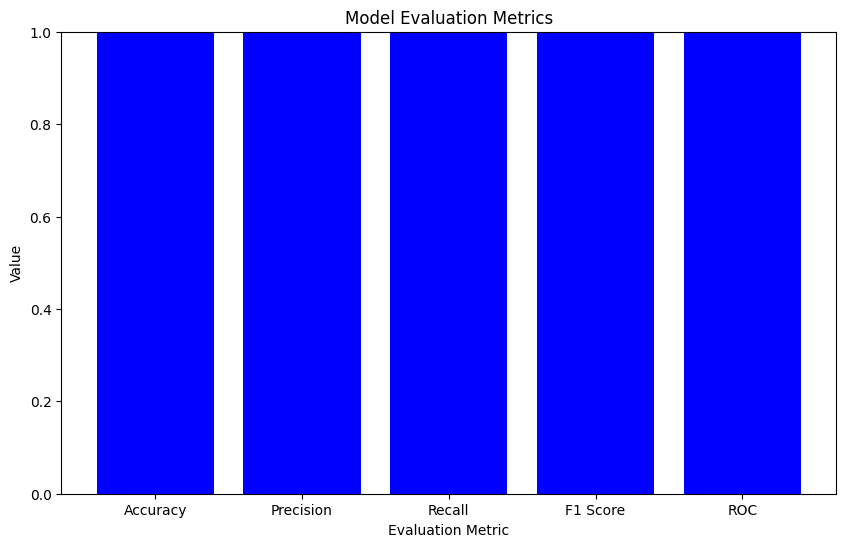

In [223]:
# Define the evaluation metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC']
values = [accuracy, precision, recall, f1_score, roc]

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='blue')
plt.xlabel('Evaluation Metric')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

Vitualize to compare the training time with different cluster structure

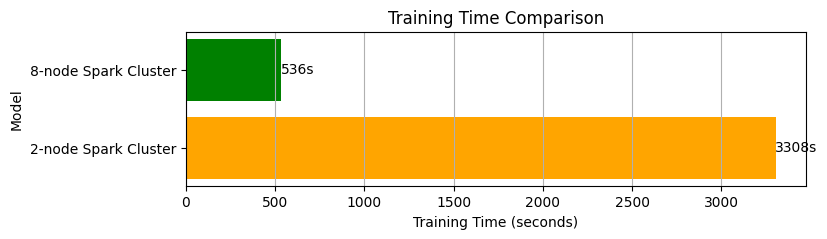

In [225]:
# Data
models = ['2-node Spark Cluster', '8-node Spark Cluster']
training_times = [3308, 536]  # Replace with your actual training times in seconds

# Plot
plt.figure(figsize=(8, 2))
bars = plt.barh(models, training_times, color=['orange', 'green'])

# Add value on top of each bar
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}s', va='center')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Model')
plt.title('Training Time Comparison')
plt.grid(axis='x')
plt.show()